<a href="https://colab.research.google.com/github/rdg55065/section2_project/blob/main/N24x_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, roc_auc_score, accuracy_score

from xgboost import XGBClassifier

import warnings 
warnings.filterwarnings(action='ignore')

import eli5
from eli5.sklearn import PermutationImportance


In [ ]:
path = 'C:\\Users\\user\\Do_It_Python\\Codestates\\Section2\\N24x\\dataset_weather\\'

# 데이터 불러오기
weather = pd.read_csv(path+'london_weather.csv')
weather.drop(columns='snow_depth', inplace=True)

# 1. 데이터 EDA 및 전처리
## 1-1. 데이터 특성 소개
- date              : 날짜
- clould_cover      : 구름이 하늘을 덮은 정도를 Oktas로 표현한 값.
- sunshine          : 1시간 동안 햇빛 측정한 값 (hrs)
- global_radiation  : 1$m^2$에 복사 조도 측정값 (W/$m^2$)
- max_temp          : 최고 온도 (˚C)
- mean_temp         : 평균 온도 (˚C)
- min_temp          : 최저 온도 (˚C)
- precipitation     : 강수량 (mm)
- pressure          : 대기압 (Pa)

In [ ]:
# 데이터 기본 정보
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.1 MB


In [ ]:
weather.shape

(15341, 9)

In [ ]:
# 데이터 확인
weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0
...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0


-> 1979년도부터 2020년도까지의 데이터임을 확인할 수 있다.

## 1-2. 데이터 EDA 및 전처리

### 1-2-1. 중복치

In [ ]:
# 중복치 확인
print(weather.duplicated().sum())
print(weather['date'].duplicated().sum())

0
0


-> 중복치가 없으며 날짜도 동일한 날짜가 없음을 알 수 있다.

### 1-2-2. 결측치

In [ ]:
## 결측치 확인
weather.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
dtype: int64

In [ ]:
# 강수는 target 데이터 이므로 결측치 삭제. 
idx_precipitation = weather[weather['precipitation'].isna()].index

weather.drop(idx_precipitation, inplace=True)
weather.reset_index(drop=True, inplace=True)

In [ ]:
# 강수데이터 결측치 제거 후 결측치 확인
weather.isna().sum()

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             2
mean_temp           32
min_temp             1
precipitation        0
pressure             4
dtype: int64

In [ ]:
# 결측치 앞뒤로 3개 데이터 확인하는 함수 생성
def find_na(df, column):
    indexs = df[df[column].isna()].index
    # print(indexs)
    for idx in indexs:
        print(f'index: {idx}, {column} 결측치의 앞뒤 3개 데이터')
        print(df[column].iloc[idx-3:idx+3])

In [ ]:
find_na(weather, 'cloud_cover')

index: 14, cloud_cover 결측치의 앞뒤 3개 데이터
11    3.0
12    1.0
13    7.0
14    NaN
15    8.0
16    8.0
Name: cloud_cover, dtype: float64
index: 20, cloud_cover 결측치의 앞뒤 3개 데이터
17    8.0
18    8.0
19    7.0
20    NaN
21    8.0
22    7.0
Name: cloud_cover, dtype: float64
index: 37, cloud_cover 결측치의 앞뒤 3개 데이터
34    8.0
35    6.0
36    4.0
37    NaN
38    6.0
39    8.0
Name: cloud_cover, dtype: float64
index: 50, cloud_cover 결측치의 앞뒤 3개 데이터
47    8.0
48    8.0
49    8.0
50    NaN
51    8.0
52    5.0
Name: cloud_cover, dtype: float64
index: 56, cloud_cover 결측치의 앞뒤 3개 데이터
53    4.0
54    4.0
55    3.0
56    NaN
57    6.0
58    6.0
Name: cloud_cover, dtype: float64
index: 250, cloud_cover 결측치의 앞뒤 3개 데이터
247    0.0
248    2.0
249    4.0
250    NaN
251    6.0
252    7.0
Name: cloud_cover, dtype: float64
index: 287, cloud_cover 결측치의 앞뒤 3개 데이터
284    5.0
285    6.0
286    5.0
287    NaN
288    7.0
289    7.0
Name: cloud_cover, dtype: float64
index: 320, cloud_cover 결측치의 앞뒤 3개 데이터
317    8.0
318    8.0
3

- cloud_cover

    index 323, 324, 2188, 3254, 3970, 12011, 15335 처럼 연속 결측치가 있거나 앞뒤로 차이가 많이 나는 데이터가 존재하기도하고 19개 밖에 안되므로 드랍하기로 결정. 

In [ ]:
find_na(weather, 'global_radiation')

index: 5270, global_radiation 결측치의 앞뒤 3개 데이터
5267     88.0
5268    276.0
5269    255.0
5270      NaN
5271      NaN
5272      NaN
Name: global_radiation, dtype: float64
index: 5271, global_radiation 결측치의 앞뒤 3개 데이터
5268    276.0
5269    255.0
5270      NaN
5271      NaN
5272      NaN
5273    144.0
Name: global_radiation, dtype: float64
index: 5272, global_radiation 결측치의 앞뒤 3개 데이터
5269    255.0
5270      NaN
5271      NaN
5272      NaN
5273    144.0
5274    124.0
Name: global_radiation, dtype: float64
index: 5279, global_radiation 결측치의 앞뒤 3개 데이터
5276    103.0
5277    208.0
5278     99.0
5279      NaN
5280    110.0
5281    235.0
Name: global_radiation, dtype: float64
index: 5284, global_radiation 결측치의 앞뒤 3개 데이터
5281    235.0
5282     89.0
5283    180.0
5284      NaN
5285    297.0
5286    240.0
Name: global_radiation, dtype: float64
index: 5289, global_radiation 결측치의 앞뒤 3개 데이터
5286    240.0
5287    224.0
5288    273.0
5289      NaN
5290    160.0
5291      NaN
Name: global_radiation, dtype: 

- global_radiation 
    
    대부분 연속 결측치, 앞뒤로 값이 많이 차이 나고 19개 밖에 안되는 데이터이므로 역시 드랍 결정.

In [ ]:
find_na(weather, 'max_temp')

index: 15191, max_temp 결측치의 앞뒤 3개 데이터
15188    36.5
15189    33.5
15190    33.9
15191     NaN
15192    35.7
15193    35.5
Name: max_temp, dtype: float64
index: 15250, max_temp 결측치의 앞뒤 3개 데이터
15247    18.6
15248    17.5
15249    17.0
15250     NaN
15251    15.1
15252    14.1
Name: max_temp, dtype: float64


- max_temp
    
    앞 뒤로 차이가 안나므로 앞의 데이터로 채움. 

In [ ]:
find_na(weather, 'min_temp')

index: 15126, min_temp 결측치의 앞뒤 3개 데이터
15123    11.4
15124    12.4
15125    13.6
15126     NaN
15127     7.2
15128     8.1
Name: min_temp, dtype: float64


- min_temp
    
    앞 뒤로 차이가 많이 나므로 드랍결정.

- mean_temp
    
    평균이므로 (max_temp + min_temp)/2 로 결측치 해결.

In [ ]:
find_na(weather, 'pressure')

index: 362, pressure 결측치의 앞뒤 3개 데이터
359    102320.0
360    100380.0
361    100250.0
362         NaN
363    100350.0
364    101380.0
Name: pressure, dtype: float64
index: 10101, pressure 결측치의 앞뒤 3개 데이터
10098    100960.0
10099    100890.0
10100    101340.0
10101         NaN
10102    100950.0
10103    101950.0
Name: pressure, dtype: float64
index: 11013, pressure 결측치의 앞뒤 3개 데이터
11010    102760.0
11011    102480.0
11012    102690.0
11013         NaN
11014         NaN
11015    102010.0
Name: pressure, dtype: float64
index: 11014, pressure 결측치의 앞뒤 3개 데이터
11011    102480.0
11012    102690.0
11013         NaN
11014         NaN
11015    102010.0
11016    101470.0
Name: pressure, dtype: float64


- pressure

    앞 뒤로 별로 차이가 안나므로 앞의 데이터로 채우기.

In [ ]:
# cloud_cover, global_radiation, min_temp 결측치 제거.
idx2 = weather[weather['cloud_cover'].isna()].index
idx3 = weather[weather['global_radiation'].isna()].index
idx4 = weather[weather['min_temp'].isna()].index

weather.drop(idx2, inplace=True)
weather.drop(idx3, inplace=True)
weather.drop(idx4, inplace=True)

In [ ]:
# max_temp, pressure 결측치 앞의 데이터로 채우기

weather['max_temp'].fillna(method='ffill', inplace=True)
weather['pressure'].fillna(method='ffill', inplace=True)

In [ ]:
# mean_temp = (max_temp + min_temp)/2

weather['mean_temp'].fillna((weather['max_temp']+weather['min_temp'])/2, inplace = True)

### 1-2-3. feature engineer

- month : 계절별로 강우에 영향을 미친다고 생각하여 month라는 특성 추가

In [ ]:
# month 특성 추가
weather['month'] = weather['date'].astype('str').str[4:6].astype('int')

In [ ]:
weather['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

- target : 비가 오면(precipitation!=0) 1, 비가 안오면(precipitation==0) 0로 설정

In [ ]:
# target 설정
weather['target'] = np.where(weather['precipitation'] == 0, 0, 1)

### 1-2-4. EDA

<AxesSubplot:>

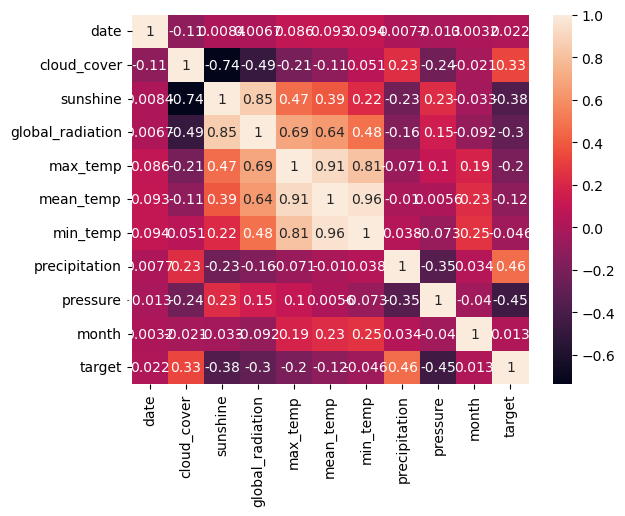

In [ ]:
sns.heatmap(weather.corr(), annot=True)

-> 크게 2가지 인사이트를 도출할 수 있다.
1. sunshine, global_radiation, pressure 값이 클수록 비가 올 확률이 낮다. (음의 상관관계)
2. cloud_cover 값이 클수록 비가 올 확률이 높다. (양의 상관관계)

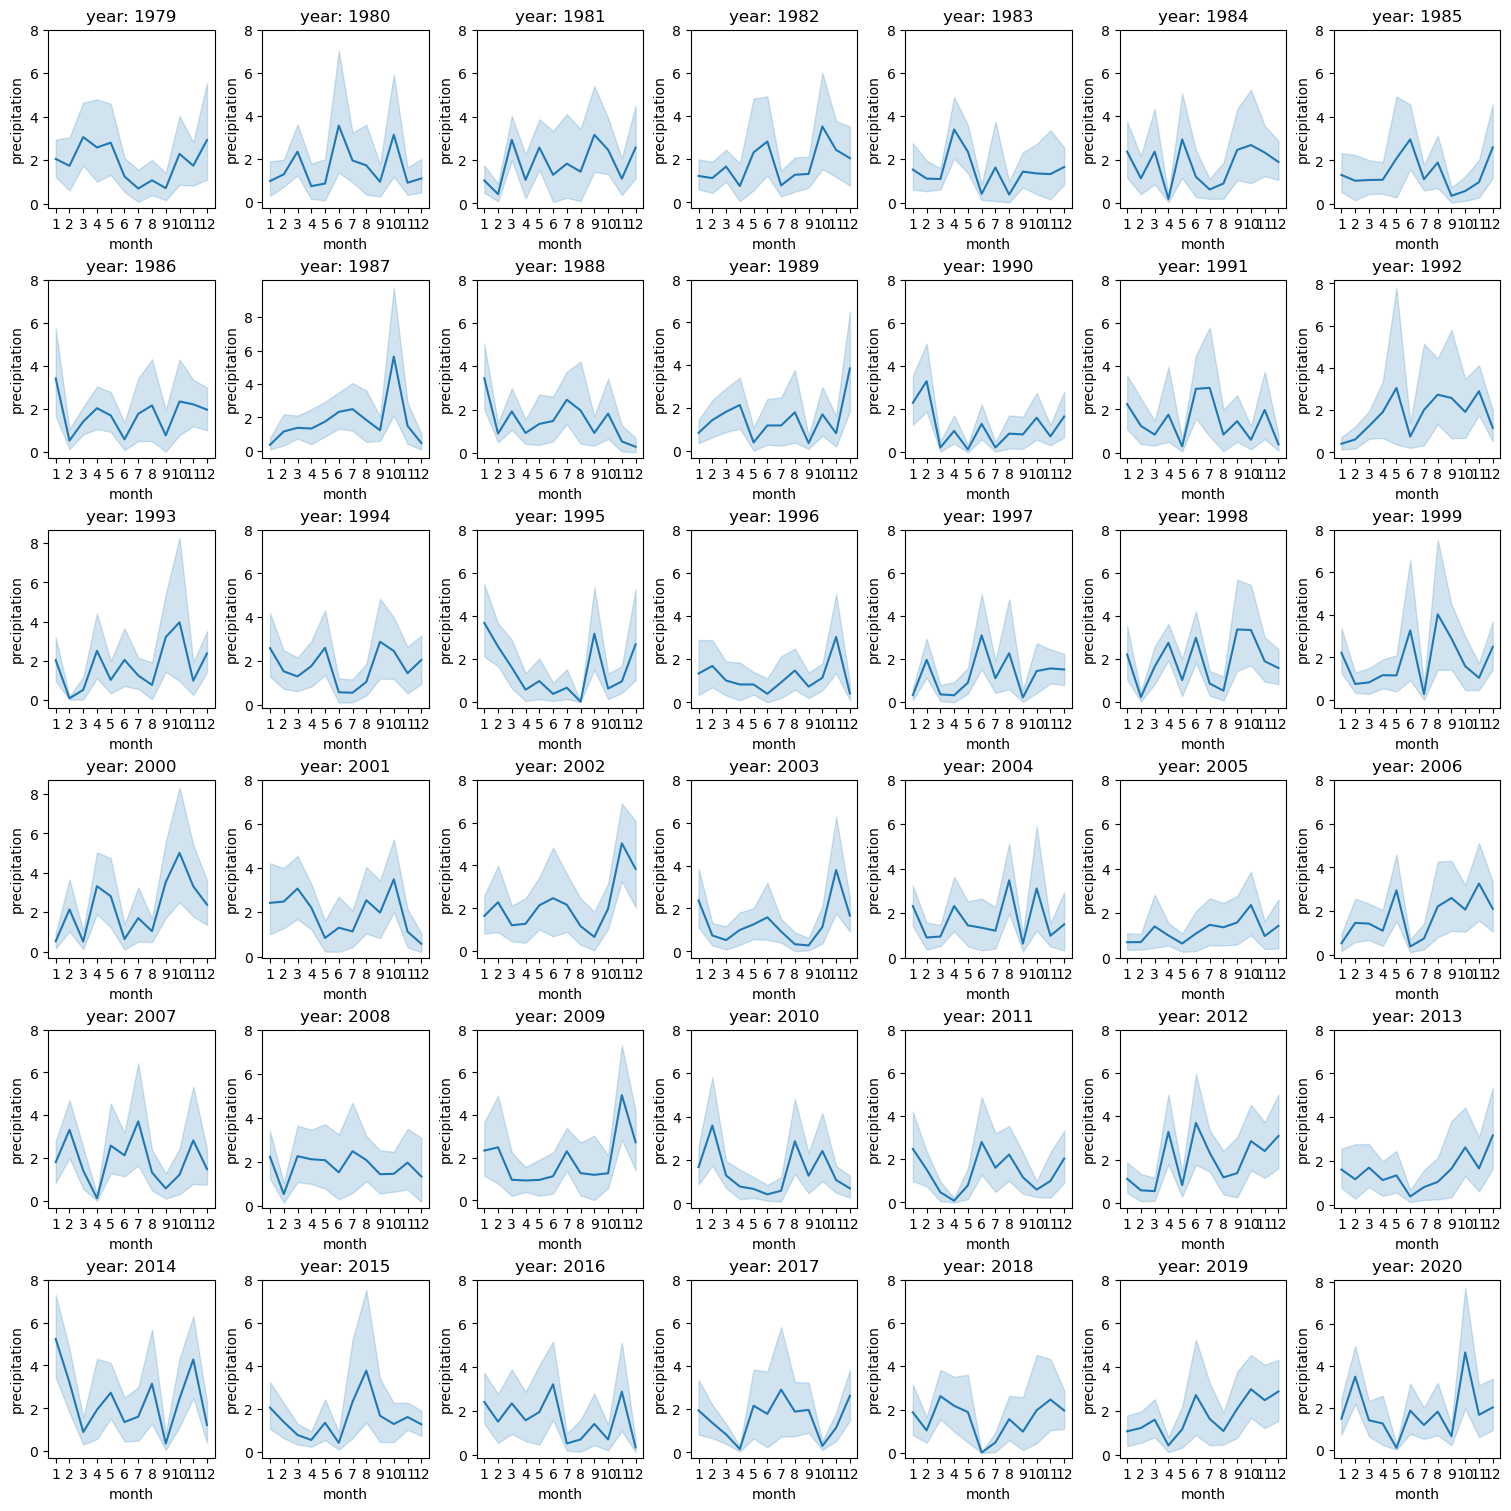

In [ ]:
# weather_ : 년도별 월별 target의 분포를 보기 위해서 year 특성을 만들어서 시각화함.

weather_ = weather.copy()
weather_['year'] = weather_['date'].astype('str').str[:4].astype('int')

years = weather_['year'].unique()

f, axes = plt.subplots(6,7, figsize=(15,15), constrained_layout=True)
for i in range(0,6):
    for j in range(0,7):
        idx = i*7 + j
        p = sns.lineplot(data=weather_[weather_['year']==years[idx]], 
                     x='month', 
                     y='precipitation',
                    ax=axes[i, j])
        p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
        p.set_yticks([0, 2, 4, 6, 8])
        p.set_title(f'year: {years[idx]}')
        

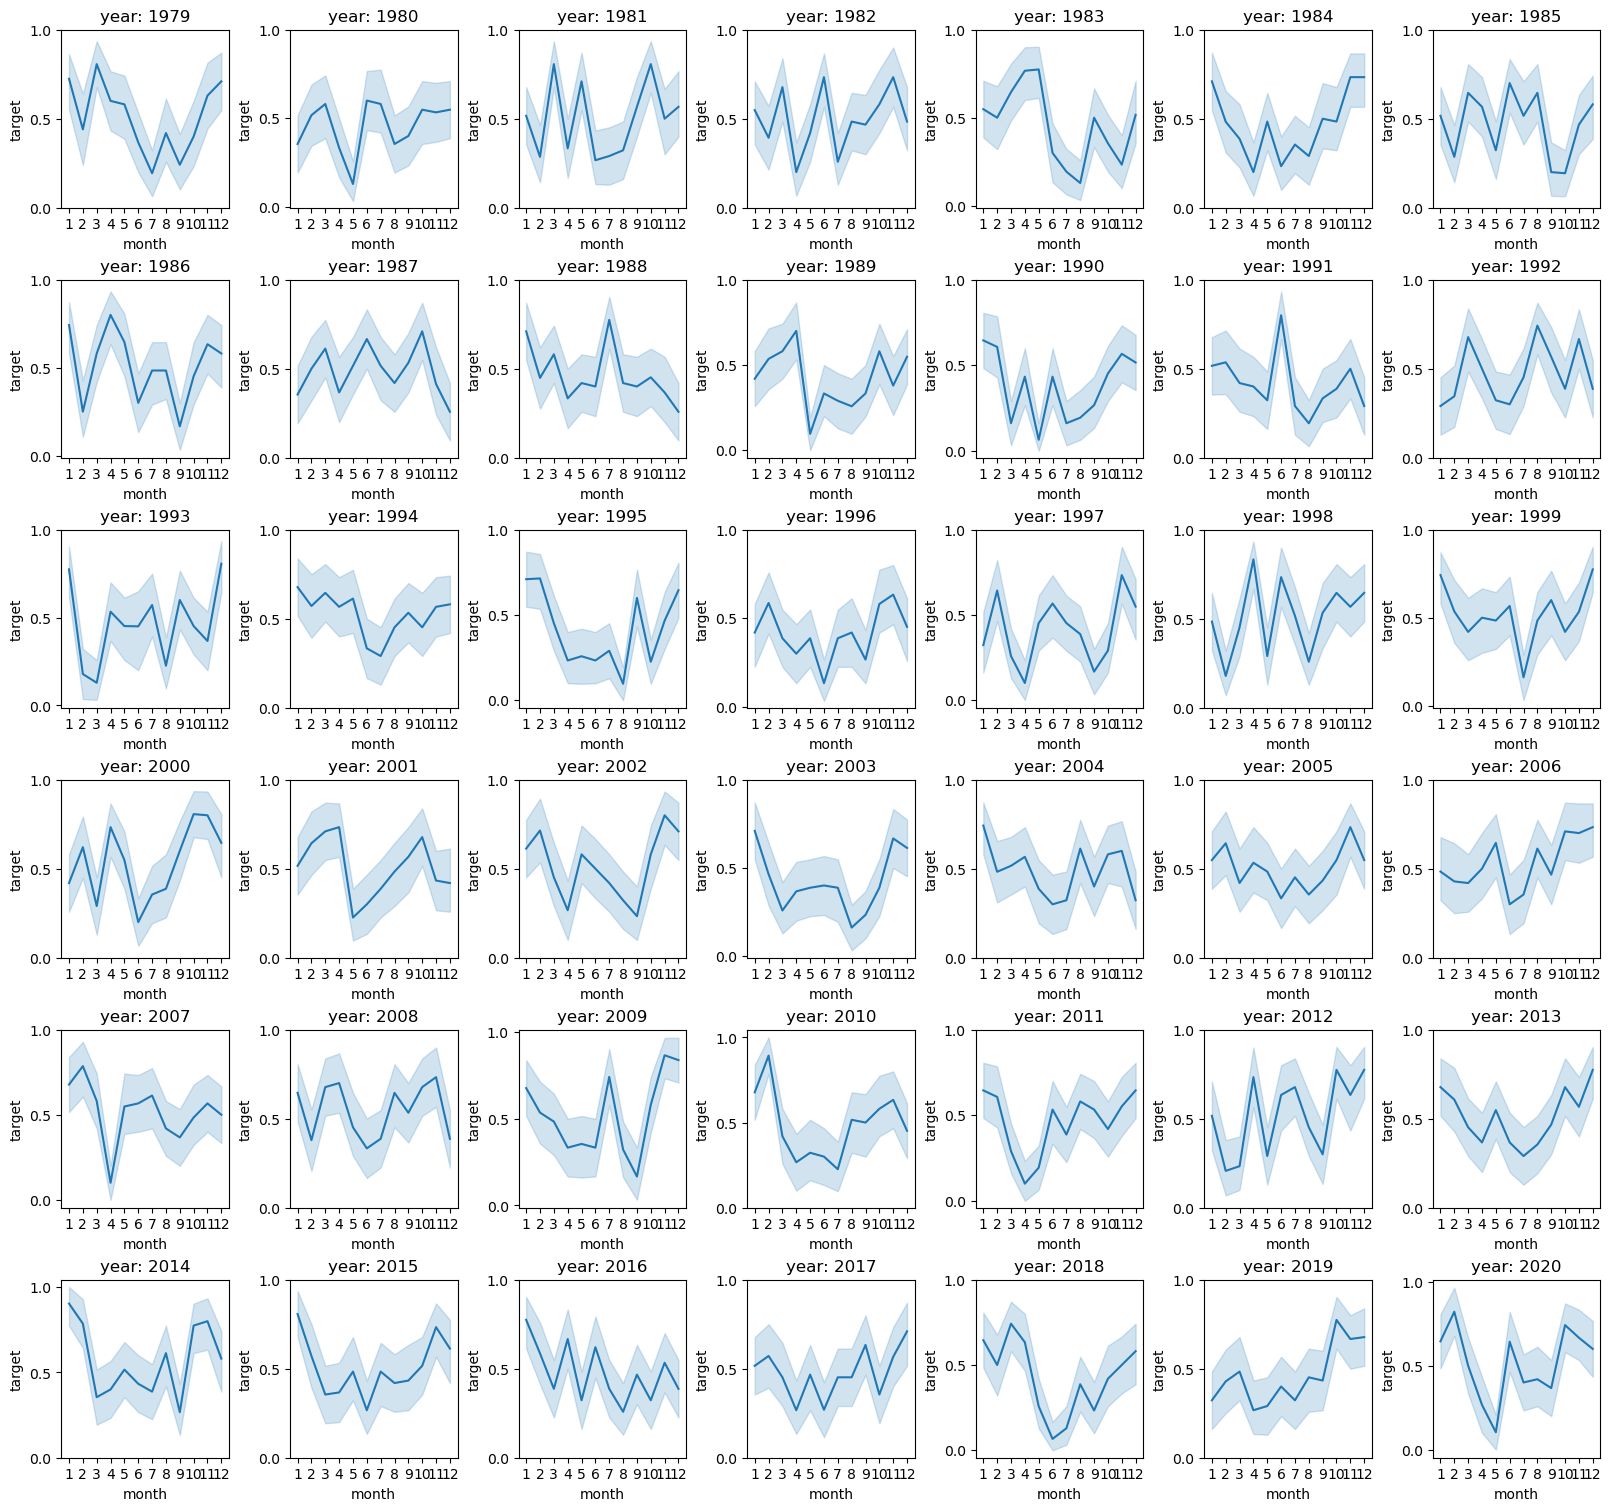

In [ ]:

weather_ = weather.copy()
weather_['year'] = weather_['date'].astype('str').str[:4].astype('int')

years = weather_['year'].unique()

f, axes = plt.subplots(6,7, figsize=(16,15), constrained_layout=True)
for i in range(0,6):
    for j in range(0,7):
        idx = i*7 + j
        p = sns.lineplot(data=weather_[weather_['year']==years[idx]], 
                     x='month', 
                     y='target',
                    ax=axes[i, j])
        p.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
        p.set_yticks([0, 0.5, 1])
        p.set_title(f'year: {years[idx]}')
        

-> 대체적으로 6,7,8월이 강수량이 낮은 것을 볼 수 있었으나, 비가 올 확률이 낮은 것은 아닌 것을 볼 수 있다.

In [ ]:
weather

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,month,target
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,1,1
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,1,0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,1,0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,1,0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15330,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,12,1
15331,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,12,1
15332,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,12,0
15333,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,12,0


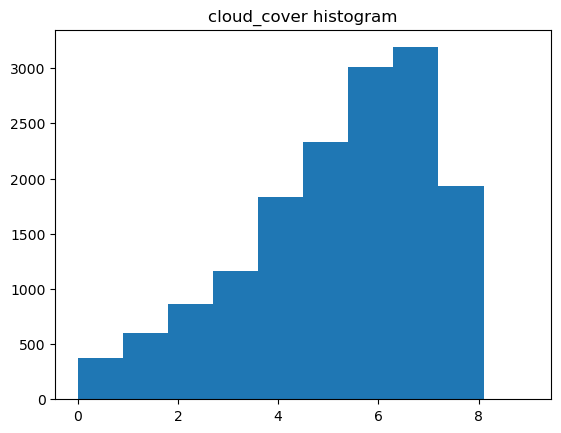

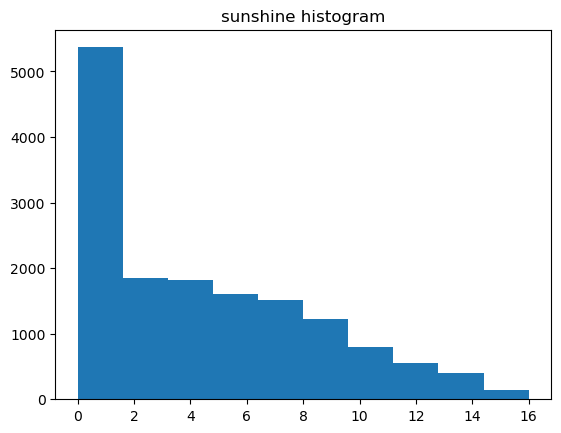

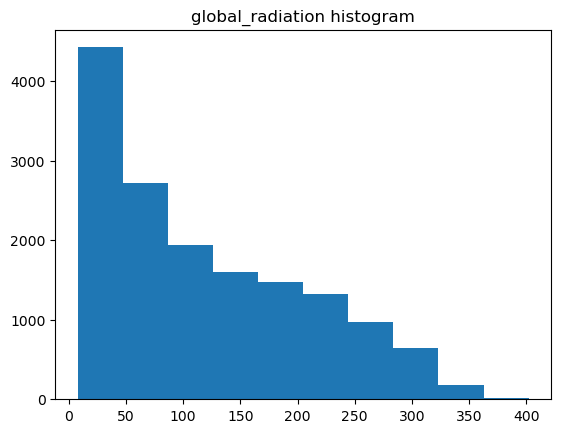

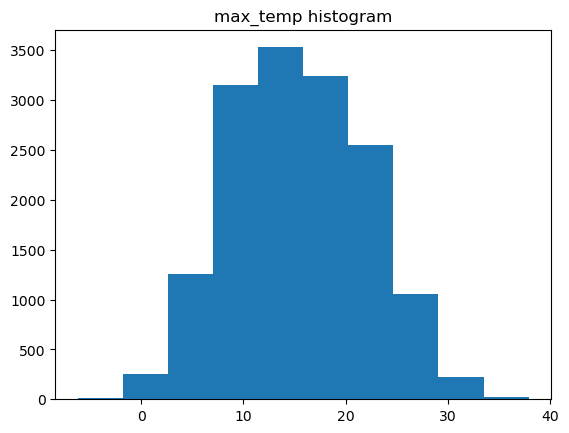

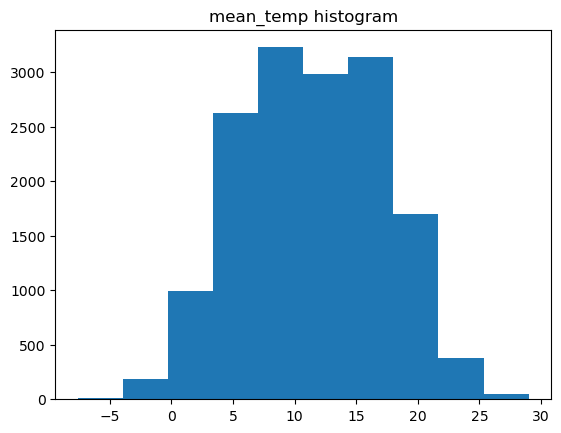

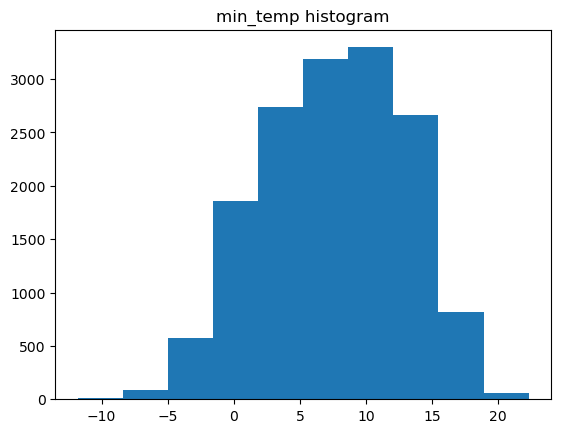

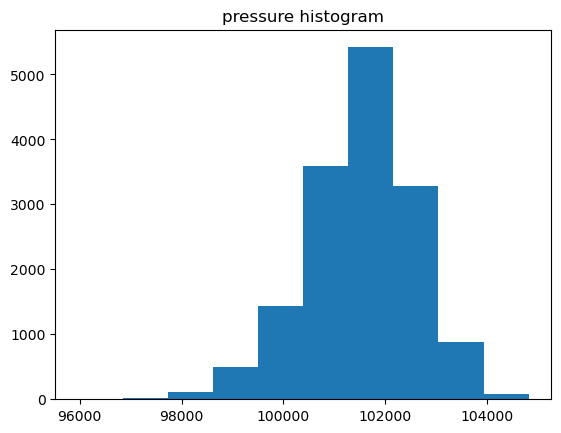

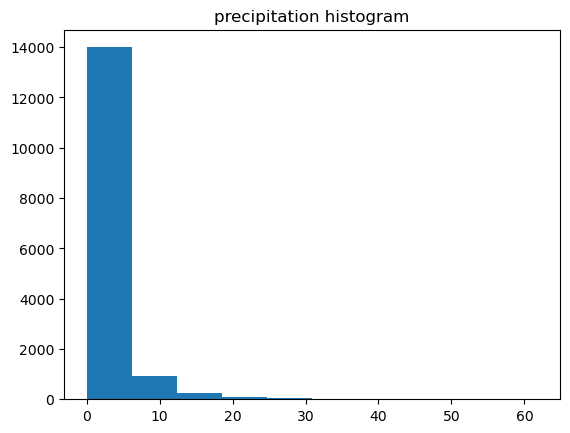

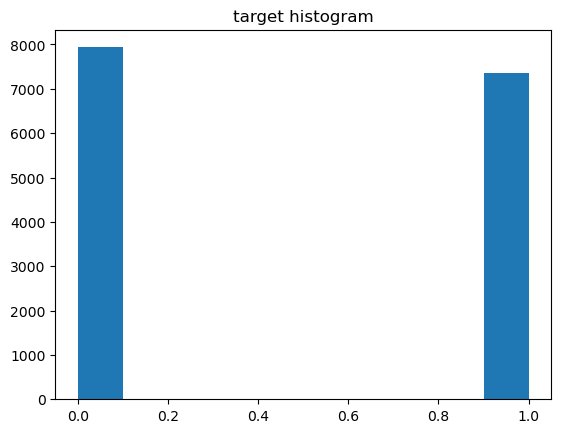

In [ ]:
features = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'pressure', 'precipitation', 'target']

for feature in features:
    plt.hist(weather[feature])
    plt.title(feature+' histogram')
    plt.show()


-> 이상치가 딱히 보이지않고, target 분포가 반반이므로 따로 분포를 바꿀 필요는 없다고 판단.

# 2. Model 설정 및 성능평가

## 2-1. training, validation, test set 분리

In [ ]:
# 데이터 누수 방지를 위해 precipitation 특성 제거 
weather_.drop(columns='precipitation', inplace=True)

In [ ]:
weather_

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,pressure,month,target,year
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,101900.0,1,1,1979
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,102530.0,1,0,1979
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,102050.0,1,0,1979
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,100840.0,1,0,1979
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,102250.0,1,0,1979
...,...,...,...,...,...,...,...,...,...,...,...
15330,20201227,1.0,0.9,32.0,7.5,7.5,7.6,98000.0,12,1,2020
15331,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,97370.0,12,1,2020
15332,20201229,7.0,0.0,21.0,4.1,2.6,1.1,98830.0,12,0,2020
15333,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,100200.0,12,0,2020


In [ ]:
# test set : 2017, 2018, 2019, 2020 데이터를 test set으로 설정
year4 = [2017, 2018, 2019, 2020]

test = weather_[weather_['year'].isin(year4)]
train = weather_[~weather_['year'].isin(year4)]

In [ ]:
# 타겟 분리 함수 생성
def split_linear(df):
    target = 'target'
    # 불필요 year 특성 제거
    df1 = df.drop(columns= ['date', 'year'])
    
    X = df1.drop(columns=target)
    y = df1[target]
    
    return X,y

In [ ]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
train.shape, val.shape

((11078, 11), (2770, 11))

In [ ]:
X_train, y_train = split_linear(train)
X_val, y_val = split_linear(val)
X_test, y_test = split_linear(test)

In [ ]:
X_train 

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,pressure,month
3707,7.0,0.0,29.0,6.1,4.1,2.0,98000.0,2
9987,5.0,1.7,125.0,17.0,11.8,6.6,102060.0,5
12470,8.0,0.0,28.0,2.5,1.4,0.5,102400.0,2
4252,5.0,3.8,149.0,27.8,22.8,18.0,102480.0,8
4852,8.0,0.0,62.0,9.3,8.5,6.9,100570.0,4
...,...,...,...,...,...,...,...,...
5205,3.0,7.1,173.0,11.3,6.3,0.6,101360.0,4
13449,5.0,1.7,49.0,15.5,13.9,11.4,100750.0,10
5417,8.0,0.0,23.0,8.1,8.8,8.0,102330.0,10
870,6.0,2.6,151.0,17.7,16.8,12.0,101350.0,5


## 2-2. 기준모델 설정

In [ ]:
base = y_train.mode()[0]
baseline = len(y_train) *[base]

In [ ]:
print(f'Baseline 정확도 : {accuracy_score(y_train, baseline).round(2)}')

Baseline 정확도 : 0.52


## 2-3. 평가지표 설정
단순 정확도(Accuracy)

비가 안왔는데(Negative) 왔다고 예측하는(False) FN, Type2 Error보다

비가 왔는데(Positive) 안왔다고 예측하는(False) FP, Type1 Error가 더 중요하게 생각하므로

재현율(Recall) 지표를 선택.

또한, 비가 올 확률을 비가 오지 않을 확률보다 확률값 자체를 높게 예측하는 것 역시 중요하므로 

ROC_AUC 지표 추가로 선택.


-> 평가지표로 정확도(Accuracy), 재현율(Recall), ROU_AUC 선택

## 2-4. RandomForest

In [ ]:
rf = RandomForestClassifier(max_depth=6,
                            n_estimators=6,
                            random_state = 42, 
                            n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=6, n_jobs=-1, random_state=42)

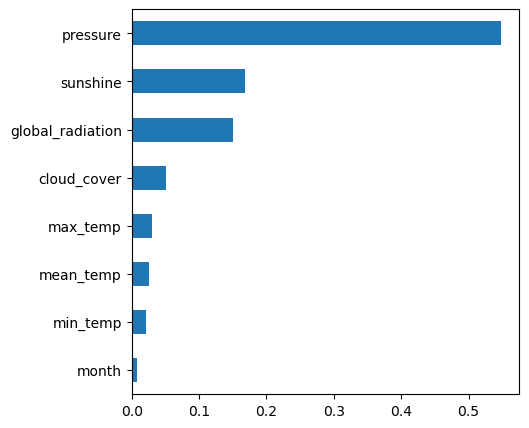

In [ ]:
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure(figsize=(5,5))
importances.sort_values().plot.barh();

In [ ]:
# 모델의 recall, roc_auc 지표를 볼 수 있는 함수 생성
def score(model):
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)

    print(f'train accuracy : {accuracy_score(y_train, y_train_pred).round(3)}')
    print(f'train recall : {recall_score(y_train, y_train_pred).round(3)}')
    print(f'train roc_auc : {roc_auc_score(y_train, y_train_pred_proba.T[1]).round(3)}')
    
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)
    
    print(f'val accuracy : {accuracy_score(y_val, y_val_pred).round(3)}')
    print(f'val recall : {recall_score(y_val, y_val_pred).round(3)}')
    print(f'val roc_auc : {roc_auc_score(y_val, y_val_pred_proba.T[1]).round(3)}')

In [ ]:
score(rf)

train accuracy : 0.755
train recall : 0.735
train roc_auc : 0.836
val accuracy : 0.745
val recall : 0.699
val roc_auc : 0.826


In [ ]:
params = {
    "max_depth": [6, 8, 10],
    "n_estimators": [6, 8, 10, 12],
}

In [ ]:
rf = RandomForestClassifier(random_state = 42, n_jobs = -1)

grid_search = GridSearchCV(rf, 
                           param_grid = params, 
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .......max_depth=6, n_estimators=6;, score=0.733 total time=   2.2s
[CV 2/3] END .......max_depth=6, n_estimators=6;, score=0.740 total time=   0.5s
[CV 3/3] END .......max_depth=6, n_estimators=6;, score=0.744 total time=   0.4s
[CV 1/3] END .......max_depth=6, n_estimators=8;, score=0.733 total time=   0.0s
[CV 2/3] END .......max_depth=6, n_estimators=8;, score=0.744 total time=   0.0s
[CV 3/3] END .......max_depth=6, n_estimators=8;, score=0.748 total time=   0.0s
[CV 1/3] END ......max_depth=6, n_estimators=10;, score=0.734 total time=   0.0s
[CV 2/3] END ......max_depth=6, n_estimators=10;, score=0.743 total time=   0.0s
[CV 3/3] END ......max_depth=6, n_estimators=10;, score=0.747 total time=   0.0s
[CV 1/3] END ......max_depth=6, n_estimators=12;, score=0.733 total time=   0.0s
[CV 2/3] END ......max_depth=6, n_estimators=12;, score=0.744 total time=   0.0s
[CV 3/3] END ......max_depth=6, n_estimators=12;

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [6, 8, 10],
                         'n_estimators': [6, 8, 10, 12]},
             scoring='accuracy', verbose=3)

In [ ]:
print('최적의 하이퍼파라미터 : ', grid_search.best_params_)
print('최적의 accuracy : ', grid_search.best_score_)

최적의 하이퍼파라미터 :  {'max_depth': 6, 'n_estimators': 12}
최적의 accuracy :  0.7422826480989432


In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
score(rf)

train accuracy : 1.0
train recall : 1.0
train roc_auc : 1.0
val accuracy : 0.753
val recall : 0.71
val roc_auc : 0.826


In [ ]:
y_test_pred = rf.predict(X_test)
y_test_pred_proba = rf.predict_proba(X_test)

print(f'test accuracy : {accuracy_score(y_test, y_test_pred).round(3)}')
print(f'test recall : {recall_score(y_test, y_test_pred).round(3)}')
print(f'test roc_auc : {roc_auc_score(y_test, y_test_pred_proba.T[1]).round(3)}')

test accuracy : 0.754
test recall : 0.722
test roc_auc : 0.833


## 2-5 XGB

In [ ]:
xgb = XGBClassifier(
    objective="binary:logistic", # 이진분류  
    random_state=42,
    n_jobs=-1,
)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
score(xgb)

train accuracy : 0.887
train recall : 0.895
train roc_auc : 0.96
val accuracy : 0.747
val recall : 0.717
val roc_auc : 0.822


In [ ]:
params = {
    "max_depth": [2, 4, 6],
    "min_child_weight": [1, 2, 4],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.3],
}

In [ ]:
xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    learning_rate=0.1,
)

grid_search = GridSearchCV(xgb,
                           param_grid=params, 
                           scoring="accuracy", 
                           cv=3, 
                           verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=1;, score=0.733 total time=   0.1s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=1;, score=0.746 total time=   0.0s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=1;, score=0.742 total time=   0.0s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=2;, score=0.734 total time=   0.0s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=2;, score=0.745 total time=   0.0s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=2;, score=0.743 total time=   0.0s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=4;, score=0.735 total time=   0.0s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=2, min_child_weight=4;, score=0.746 total

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                  

In [ ]:
print('최적의 하이퍼파라미터 : ', grid_search.best_params_)
print('최적의 accuracy : ', grid_search.best_score_.round(3))

최적의 하이퍼파라미터 :  {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 4}
최적의 accuracy :  0.746


In [ ]:
xgb.fit(X_train, y_train)

score(xgb)

train accuracy : 0.811
train recall : 0.808
train roc_auc : 0.901
val accuracy : 0.755
val recall : 0.721
val roc_auc : 0.837


In [ ]:
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)

print(f'test accuracy : {accuracy_score(y_test, y_test_pred).round(3)}')
print(f'test recall : {recall_score(y_test, y_test_pred).round(3)}')
print(f'test roc_auc : {roc_auc_score(y_test, y_test_pred_proba.T[1]).round(3)}')

test accuracy : 0.758
test recall : 0.73
test roc_auc : 0.84


-> 모든 항목에서 xgboost의 성능이 좀 더 높은 것을 확인할 수 있음.

# 3. 모델 해석

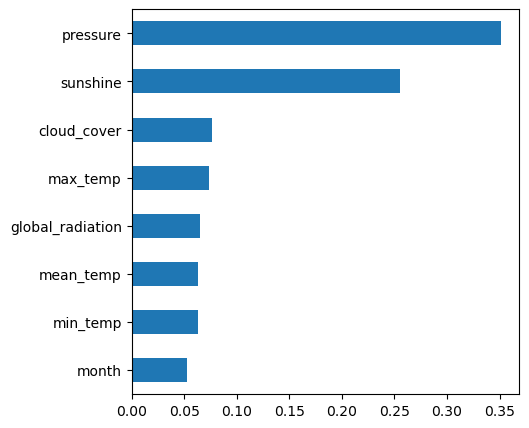

In [ ]:
importances = pd.Series(xgb.feature_importances_, X_train.columns)
plt.figure(figsize=(5,5))
importances.sort_values().plot.barh();

pressure, sunshine이 모델 예측값에 가장 많은 영향을 미치는 것을 알 수 있다. 

In [ ]:
permuter = PermutationImportance(
    xgb,
    scoring="accuracy",  # metric
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=2,
)

In [ ]:
permuter.fit(X_test, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=N

Text(0.5, 1.0, 'Permutation Importance')

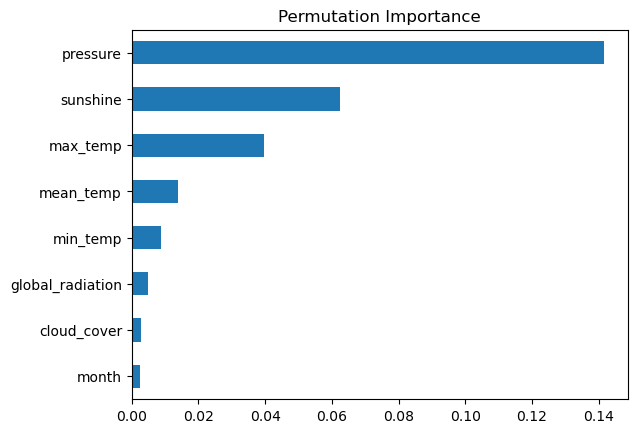

In [ ]:
feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

permutation importance는 각 특성에 노이즈를 주어 모델이 해당 특성을 의사결정을 하지 못하도록 

했을 때 성능이 얼마나 감소하는지 정도에 따라 특성의 중요도를 파악하는 방법이다.

-> 역시 pressure, sunshine이 가장 많은 영향을 미치고, 

일반적으로 구름이 하늘을 많이 덮으면(즉, cloud_cover값이 높으면) 비가 올 것으로 예측하지만

cloud_cover 특성에 노이즈를 주어도 예측값에 영향을 덜 미치는 것을 볼 수 있다.